## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import neat

#Custom imports
from config import *
import visualize
import NEAT

#Set the local directory
local_dir = os.getcwd()
neat_config_path = os.path.join(local_dir, Paths.NEAT_CONFIG_PATH)
config_path = os.path.join(local_dir, Paths.CONFIG_PATH)

# Load configuration into a NEAT object.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        neat_config_path)

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Run NEAT

In [2]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        neat_config_path)

winners_list, stats_list_baseline = NEAT.run_NEAT_repeated(neat_config_path)

best_run_idx = np.argmax([winner.fitness for winner in winners_list])
print(f"Best run: {best_run_idx} with fitness:§ {winners_list[best_run_idx].fitness}")

Running NEAT algorithm, run 0
Saving checkpoint to results//checkpoints/run0/population-0
Saving checkpoint to results//checkpoints/run0/population-1
Saving checkpoint to results//checkpoints/run0/population-2
Saving checkpoint to results//checkpoints/run0/population-3
Saving checkpoint to results//checkpoints/run0/population-4
Run 0 completed, best fitness: 2.0
Best run: 0 with fitness:§ 2.0


In [3]:
visualize.test_winner(winners_list[-1], neat_config_path)

In [3]:
winners_list, stats_list = NEAT.run_NEAT_repeated(neat_config_path)

best_run_idx = np.argmax([winner.fitness for winner in winners_list])
print(f"Best run: {best_run_idx} with fitness: {winners_list[best_run_idx].fitness}")

Running NEAT algorithm, run 0


KeyboardInterrupt: 

In [1]:
average_fitness_baseline = np.mean([np.array(stats.get_fitness_mean())[-1] for stats in stats_list_baseline])
std_fitness_baseline = np.std([np.array(stats.get_fitness_mean())[-1] for stats in stats_list_baseline])

# Calculate average fitness and standard deviation over all runs
average_fitness= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in stats_list])
std_fitness = np.std([np.array(stats.get_fitness_mean())[-1] for stats in stats_list])

average_fitness= 10.3

# Data to plot
fitness_means = [average_fitness_baseline, average_fitness]
fitness_stds = [std_fitness_baseline, std_fitness]
labels = ['NSWE', 'Snake FoR']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954'])
ax.set_ylabel('Average Fitness')
ax.set_title(f'Average Fitness over {Config.N_RUNS} Runs after {Config.N_GENERATIONS} Generations')

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/fitness_comparison.png')
plt.show()

NameError: name 'np' is not defined

In [5]:
#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + '/winners_list', winners_list)
np.save(local_dir + '/' + Paths.RESULTS_PATH + '/stats_list', stats_list)

In [6]:
# Load the data
# winners_list = np.load(local_dir + '/experiment_1/winners_list.npy', allow_pickle=True)
# stats_list = np.load(local_dir + '/experiment_1/stats_list.npy', allow_pickle=True)

## Evaluate Results

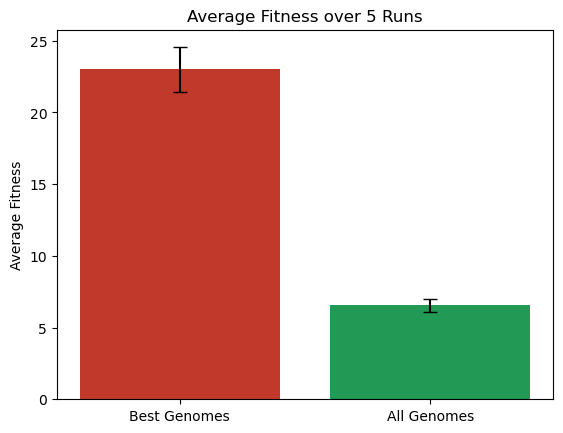

In [7]:
# Calculate average fitness and standard deviation for winners
average_fitness_winners = np.mean([winner.fitness for winner in winners_list])
std_fitness_winners = np.std([winner.fitness for winner in winners_list])

# Calculate average fitness and standard deviation over all runs
average_fitness = np.mean([np.array(stats.get_fitness_mean())[-1] for stats in stats_list])
std_fitness = np.std([np.array(stats.get_fitness_mean())[-1] for stats in stats_list])

# Data to plot
fitness_means = [average_fitness_winners, average_fitness]
fitness_stds = [std_fitness_winners, std_fitness]
labels = ['Best Genomes', 'All Genomes']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954'])
ax.set_ylabel('Average Fitness')
ax.set_title(f'Average Fitness over {Config.N_RUNS} Runs')

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/fitness_comparison.png')
plt.show()

### Plot the best genome

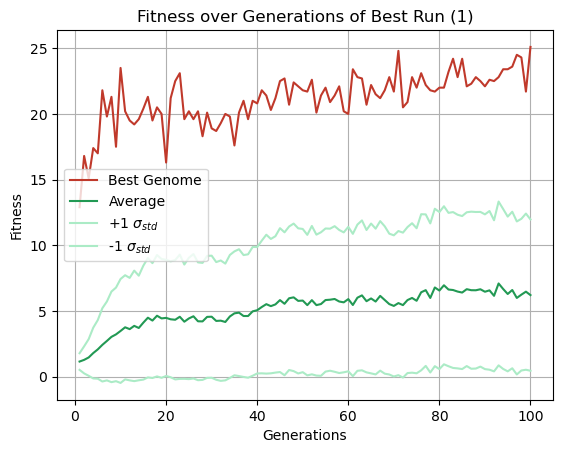

In [8]:
#Get statistics from the best run
winner_stats = stats_list[best_run_idx]
generations = range(1, Config.N_GENERATIONS + 1)
best_fitnesses = [g.fitness for g in winner_stats.most_fit_genomes]
avg_fitnesses = np.array(winner_stats.get_fitness_mean())
stdev_fitnesses = np.array(winner_stats.get_fitness_stdev())


plt.plot(generations, best_fitnesses, color = '#c0392b', label="Best Genome")
plt.plot(generations, avg_fitnesses, color = '#229954', label="Average")
plt.plot(generations, avg_fitnesses + stdev_fitnesses, color = '#abebc6', label="+1 $\sigma_{std}$")
plt.plot(generations, avg_fitnesses - stdev_fitnesses, color = '#abebc6', label="-1 $\sigma_{std}$")


# plt.title(f"Best Run ({best_run_idx + 1}) Results")
plt.title(f"Fitness over Generations of Best Run ({best_run_idx + 1})") 
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.grid()
plt.legend(loc="best")


plt.show()

### Compare the best snake at different generations

In [9]:
generation_nr_1 = 310
generation_nr_2 = 410

# Get the best genome at every generation
best_genomes = [g for g in winner_stats.most_fit_genomes]

genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

IndexError: list index out of range

In [ ]:
best_genomes = [g for g in winner_stats.most_fit_genomes]

visualize.test_winner(genome_1, config_path) 

In [ ]:
visualize.test_winner(genome_2, config_path) 

### Plot the best solution of each run separately

In [ ]:
#Get statistics from all runs
stats = stats_list[best_run_idx]
generations = range(1, Config.N_GENERATIONS + 1)

# Get the best genome at every generation
best_genomes = [[g for g in stats.most_fit_genomes] for stats in stats_list]

# Plot the best genome of each run
for i, genome in enumerate(best_genomes):
    best_fitnesses = [g.fitness for g in genome]
    plt.plot(generations, best_fitnesses, label=f"Run {i + 1}")

plt.title(f"Best Genome of each Run")
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.grid()
plt.legend(loc="best")

plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/best_genomes_each_run.png')
plt.show()

### Visualize speciation of best run

In [ ]:
species_sizes = np.array(winner_stats.get_species_sizes())
num_generations = len(species_sizes)
curves = np.array(species_sizes).T

fig, ax = plt.subplots()
ax.stackplot(range(num_generations), *curves)

plt.title("Speciation")
plt.ylabel("Size per Species")
plt.xlabel("Generations")

plt.show()


In [ ]:
total_species_fitness = np.array(winner_stats.get_species_fitness())

print(total_species_fitness[:, 0])
print(species_sizes[:, 0])

print(total_species_fitness)

In [ ]:
species_fitness = np.array(winner_stats.get_species_fitness())

num_generations = len(species_sizes)


for i in range (len(species_fitness[0])):
    # Extract the column corresponding to the species
    species_data = species_fitness[:, i]
    
    # Filter out empty strings and convert to float
    valid_fitness = np.array([float(x) for x in species_data if x != ''])
    
    # Get the valid indices to match the generations
    valid_indices = np.where(species_data != '')[0]

    
    # Plot only the valid data points
    plt.plot(valid_indices, valid_fitness, label=f"Species {i}")

plt.title("Speciation")
plt.ylabel("Species Fitness")
plt.xlabel("Generations")
# plt.yscale('log')
plt.legend()

plt.show()


### Plot the n best solutions over all runs [NOT IMPLEMENTED]

In [ ]:
stats = stats_list[best_run_idx]
n_best_genomes =  stats.best_unique_genomes(5)

n_best_genomes_fitness = [g.fitness for g in n_best_genomes]
n_best_genomes_id = np.argpartition(n_best_genomes_fitness, -3)[-3:]
print(n_best_genomes_fitness)
print(n_best_genomes_id)

In [ ]:
n = 5

# Get the n best genomes from all runs
all_best_genomes = []
for stats in stats_list:
    all_best_genomes += stats.best_unique_genomes(n)

all_best_fitness = [g.fitness for g in all_best_genomes]
n_best_genomes_id = np.argpartition(all_best_fitness, -n)[-n:]


plt.figure()
generations = range(1, Config.N_RUNS + 1)
for id in n_best_genomes_id:
    genome = all_best_genomes[id]
    best_fitnesses = [g.fitness for g in genome]
    plt.plot(generations, best_fitnesses)

plt.plot(generations, best_fitnesses, 'r-', label="best")

plt.title(f"Best Run ({best_run_idx + 1}) Results")
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.grid()
plt.legend(loc="best")

plt.show()

### Checkpoint restoration [DOES NOT WORK PROPERLY FOR NOW]

If I restore a checkpoint, and then check the fitness of that population, it does not match up with the graphs above. I am not sure why. I will try to figure it out later, if we will actually need to use this.

In [ ]:
generation_nr_1 = 18
population_1 = neat.Checkpointer.restore_checkpoint(f'results/checkpoints/run{best_run_idx}/population-{generation_nr_1}')

genome_tuples = list(iter(population_1.population.items()))   # List of (genome_id, genome) tuples.

# Assign a fitness value to each genome
NEAT.eval_genomes(genome_tuples, config)

# Get the best genome of the generation
genomes = population_1.population.values() # List of the genomes after evaluation.
best_genome = None
for i, g in enumerate(iter(genomes)):
    if best_genome is None or g.fitness > best_genome.fitness:
        best_genome = g

print(f"Best genome has fitness: {best_genome.fitness}")